#### 5. Develop an anomaly detection system for high-dimensional network traffic data using the KDD Cup 1999 dataset.

In [2]:
import pandas as pd
import numpy as np

In [3]:
import requests

files = [
    ("https://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz", "kddcup.data_10_percent.gz"),
    ("https://kdd.ics.uci.edu/databases/kddcup99/kddcup.names", "kddcup.names")
]

for url, filename in files:
    print(f"Downloading {filename}...")
    response = requests.get(url)
    with open(filename, 'wb') as f:
        f.write(response.content)
    print(f"Downloaded {filename}")

Downloaded kddcup.data_10_percent.gz
Downloaded kddcup.names


In [4]:
with open("kddcup.names", 'r') as f:
    lines = f.readlines()

column_names = [line.split(':')[0].strip() for line in lines[1:]]
column_names.append("label")

In [5]:
df = pd.read_csv("kddcup.data_10_percent.gz", header=None, names=column_names)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494021 entries, 0 to 494020
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     494021 non-null  int64  
 1   protocol_type                494021 non-null  object 
 2   service                      494021 non-null  object 
 3   flag                         494021 non-null  object 
 4   src_bytes                    494021 non-null  int64  
 5   dst_bytes                    494021 non-null  int64  
 6   land                         494021 non-null  int64  
 7   wrong_fragment               494021 non-null  int64  
 8   urgent                       494021 non-null  int64  
 9   hot                          494021 non-null  int64  
 10  num_failed_logins            494021 non-null  int64  
 11  logged_in                    494021 non-null  int64  
 12  num_compromised              494021 non-null  int64  
 13 

In [10]:
df['label'] = df['label'].astype('category')

In [11]:
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


In [12]:
print(df.isnull().sum())

duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_h

In [13]:
from sklearn.preprocessing import LabelEncoder

for col in ["protocol_type", "service", "flag"]:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

In [16]:
from sklearn.preprocessing import StandardScaler

numeric_cols = df.select_dtypes(include=['number']).columns.tolist()

scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

In [19]:
# Training an Isolation Forest Model
from sklearn.ensemble import IsolationForest

iso_forest = IsolationForest(contamination=0.1, random_state=42)
df['anomaly_score'] = iso_forest.fit_predict(df[numeric_cols])


df['anomaly'] = df['anomaly_score'].apply(lambda x: 1 if x == -1 else 0)

print(df['anomaly'].value_counts())

anomaly
0    444619
1     49402
Name: count, dtype: int64


In [20]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

df['binary_label'] = df['label'].apply(lambda x: 1 if x != 'normal.' else 0)

In [21]:
print("Isolation Forest Metrics:")
print(classification_report(df['binary_label'], df['anomaly']))
print("AUC-ROC Score: ", roc_auc_score(df['binary_label'], df['anomaly']))
print("Confusion Matrix: \n", confusion_matrix(df['binary_label'], df['anomaly']))

Isolation Forest Metrics:
              precision    recall  f1-score   support

           0       0.18      0.80      0.29     97278
           1       0.61      0.08      0.14    396743

    accuracy                           0.22    494021
   macro avg       0.39      0.44      0.21    494021
weighted avg       0.52      0.22      0.17    494021

AUC-ROC Score:  0.43901137415494984
Confusion Matrix: 
 [[ 78021  19257]
 [366598  30145]]


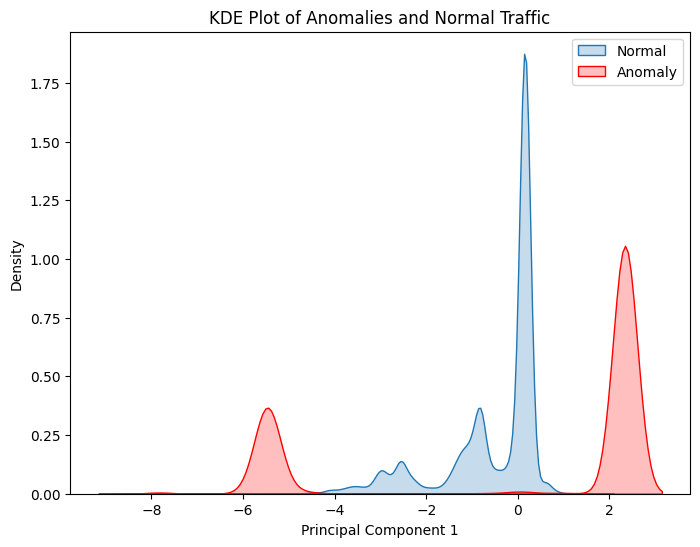

In [ ]:
# Dimensionality Reduction with PCA (OPTIONAL)

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

pca = PCA(n_components=2)
df_pca = pca.fit_transform(df[numeric_cols])

df_pca = pd.DataFrame(df_pca, columns=['PC1', 'PC2'])

# Visualisation
df_pca['binary_label'] = df['label'].apply(lambda x: 1 if x != 'normal.' else 0)

plt.figure(figsize=(8, 6))
sns.kdeplot(df_pca[df_pca['binary_label']==0]['PC1'], label='Normal', fill=True)
sns.kdeplot(df_pca[df_pca['binary_label']==1]['PC1'], label='Anomaly', fill=True, color='r')
plt.xlabel('Principal Component 1')
plt.ylabel('Density')
plt.title("KDE Plot of Anomalies and Normal Traffic")
plt.legend()
plt.show()